## Estimation Example



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [1]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



#### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/](https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ugandan example that I wish to work
through.



In [2]:
data = '1OWluIYUGkmR6iFgSzJJa2ikEqqMT6BHbsKZyip236HU'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [3]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Change 'Uganda_Data' to key of your own sheet in Sheets, above
x = read_sheets(data,sheet='Food Expenditures 2015')
x.drop(['j'], axis=1, inplace=True)
print(x.columns)
x.rename(columns={'food_name':'j'}, inplace=True)
x = x.set_index(['i','t','m','j']).squeeze()


# Now prices
#p = read_sheets(data,sheet='Food Prices (2018-19)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
#p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
#p = p.xs('kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
#p = p[x.index.levels[-1]].T

# Household characteristics
d = read_sheets(data,sheet="Household Characteristics 2015")
d.columns.name = 'k'
d['sex'] = d['sex'].map({'Female': 1, 'Male': 0})
d['log_household'] = np.log(d['HH_size'])
d.drop('HH_size', axis=1, inplace=True)

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

display(x)

# Take logs of expenditures; call this y
y = np.log(x)

d.set_index(['i','t','m'],inplace=True)

Index(['i', 't', 'm', 'grams', 'food_name'], dtype='object')


i      t     m    j                                                          
83732  2015  USA  Banana, raw                                                    202.0
                  Beans, string, cooked, from canned, ns as to color, fat not    202.5
                  Bread, white, toasted                                           75.0
                  Burrito, taco, or quesadilla with egg and breakfast meat       222.0
                  Chicken breast, baked, coated, skin / coating eaten            175.0
                                                                                 ...  
93702  2015  USA  Turkey, prepackaged or deli, luncheon meat, reduced sodium      56.0
                  Walnuts, nfs                                                    40.0
                  Water, bottled, unsweetened                                    507.0
                  Water, tap                                                     690.0
                  Wine, table, red                  

This gives a dataframe of household characteristics $d$ with a simple structure.



In [4]:
print(d.head())

k                age  sex  log_household
i     t    m                            
83732 2015 USA  62.0    0       0.693147
83733 2015 USA  53.0    0       0.000000
83734 2015 USA  78.0    0       0.693147
83735 2015 USA  56.0    1       0.000000
83736 2015 USA  42.0    1       1.609438


def get_bin(age):
    if pd.isna(age):
        return 'NA'
    elif age <= 3:
        return '00-03'
    elif age <= 8:
        return '04-08'
    elif age <= 13:
        return '09-13'
    elif age <= 18:
        return '14-18'
    elif age <= 30:
        return '19-30'
    elif age <= 50:
        return '31-50'
    else:
        return '51+'

d['age_bin'] = d['age'].apply(get_bin)
d['sex_age_bin'] = d['sex'].str[0] + ' ' + d['age_bin']
bin_counts = d.groupby(['i', 't', 'm', 'sex_age_bin']).size().unstack(fill_value=0)
hh_info = d.groupby(['i', 't', 'm']).agg({'HH_size': 'first'})
hh_info['log HSize'] = np.log(hh_info['HH_size'])
for sex in ['M', 'F']:
    col = f'{sex} NA'
    bin_counts[col] = bin_counts.get(col, 0)
result = pd.concat([bin_counts, hh_info[['log HSize']]], axis=1).fillna(0)
result = result.sort_index(axis=1)
display(result)

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [5]:
y.head()

i      t     m    j                                                          
83732  2015  USA  Banana, raw                                                    5.308268
                  Beans, string, cooked, from canned, ns as to color, fat not    5.310740
                  Bread, white, toasted                                          4.317488
                  Burrito, taco, or quesadilla with egg and breakfast meat       5.402677
                  Chicken breast, baked, coated, skin / coating eaten            5.164786
Name: grams, dtype: float64

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### nutrition sourcing



In [7]:
foods = []
for f in y_small.index:
    foods.append(f[-1])
set(foods)

{'Almond milk, unsweetened',
 'Apple, raw',
 'Banana, raw',
 'Beans, lima, immature, cooked, from frozen, fat not added in',
 'Beans, string, cooked, from canned, ns as to color, fat not',
 'Beef steak, fried, lean only eaten',
 'Beer, light',
 'Bread, french or vienna',
 'Bread, wheat or cracked wheat',
 'Bread, wheat or cracked wheat, toasted',
 'Bread, white, toasted',
 'Bread, whole wheat',
 'Burrito, taco, or quesadilla with egg and breakfast meat',
 'Butter, stick, salted',
 'Cabbage salad or coleslaw, made with any type of fat free dr',
 'Catfish, coated, fried, made with oil',
 'Celery, raw',
 "Cereal (kellogg's corn flakes)",
 'Cheese, american',
 'Cheeseburger, 1 medium patty, with condiments, on bun, from',
 'Chicken "wings" with other sauces or seasoning, from fast fo',
 'Chicken breast, baked, coated, skin / coating eaten',
 'Chicken fillet, broiled, sandwich with cheese, on whole whea',
 'Chicken with mole sauce',
 'Chocolate, sweet or dark',
 'Chocolate, sweet or dark, w

In [10]:
!pip install fooddatacentral
!pip install pint
import fooddatacentral as fdc
apikey = 'qYfiIXBSE9aR5gcHh5N8VxYYfQ2MXs4yOEXb1kv6'
fdc.search(apikey,"marmite")

  Using cached fooddatacentral-1.0.10-py3-none-any.whl.metadata (1.9 kB)
Using cached fooddatacentral-1.0.10-py3-none-any.whl (6.8 kB)
  Using cached Pint-0.24.4-py3-none-any.whl.metadata (8.5 kB)
  Using cached flexcache-0.3-py3-none-any.whl.metadata (7.0 kB)
  Using cached flexparser-0.4-py3-none-any.whl.metadata (18 kB)
Using cached Pint-0.24.4-py3-none-any.whl (302 kB)
Using cached flexcache-0.3-py3-none-any.whl (13 kB)
Using cached flexparser-0.4-py3-none-any.whl (27 kB)


,fdcId,description,commonNames,additionalDescriptions,dataType,foodCode,publishedDate,foodCategory,foodCategoryId,allHighlightFields,...,ingredients,marketCountry,modifiedDate,dataSource,packageWeight,servingSizeUnit,servingSize,householdServingFullText,shortDescription,tradeChannels
0,2710006,Yeast extract spread,,Promite;Vegemite;Marmite,Survey (FNDDS),75236500.0,2024-10-31,Mustard and other condiments,3307560.0,<b>Includes</b>: Promite;Vegemite;<em>Marmite<...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2665444,YEAST EXTRACT,NaN,NaN,Branded,NaN,2023-11-16,Baking Additives & Extracts,NaN,,...,"YEAST EXTRACT, SALT, CARROT AND ONION EXTRACTS...",United States,2017-07-14,LI,4.4 oz/125 g,GRM,4.0,0.5 tsp,,[NO_TRADE_CHANNEL]


In [13]:
frames = []
for item in foods:
    fframe = fdc.search(apikey, item)
    frames.append(fframe)
tps = [type(bit) for bit in frames]
display(frames[0])

,fdcId,description,commonNames,additionalDescriptions,dataType,foodCode,publishedDate,foodCategory,foodCategoryId,allHighlightFields,...,microbes,foodNutrients,finalFoodInputFoods,foodMeasures,foodAttributes,foodAttributeTypes,foodVersionIds,scientificName,ndbNumber,mostRecentAcquisitionDate
0,2709224,"Banana, raw",,,Survey (FNDDS),63107010.0,2024-10-31,Bananas,3305996.0,,...,[],"[{'nutrientId': 1003, 'nutrientName': 'Protein...","[{'foodDescription': 'Bananas, overripe, raw',...","[{'disseminationText': '1 cup, mashed', 'gramW...","[{'value': 'Bananas', 'name': 'WWEIA Category ...","[{'name': 'Adjustments', 'description': 'Adjus...",[],NaN,NaN,NaN
1,173944,"Bananas, raw",,,SR Legacy,NaN,2019-04-01,Fruits and Fruit Juices,NaN,,...,[],"[{'nutrientId': 1186, 'nutrientName': 'Folic a...",[],[],[],[],[],Musa acuminata Colla,9040.0,NaN
2,1105073,"Bananas, overripe, raw",,,Foundation,NaN,2020-04-01,Fruits and Fruit Juices,NaN,,...,[],"[{'nutrientId': 1108, 'nutrientName': 'Caroten...",[],[],[],[],[],Musa acuminata Colla,100254.0,2019-12-15
3,169394,"Pepper, banana, raw",,,SR Legacy,NaN,2019-04-01,Vegetables and Vegetable Products,NaN,,...,[],"[{'nutrientId': 1079, 'nutrientName': 'Fiber, ...",[],[],[],[],[],Capsicum annuum,11976.0,NaN
4,2709802,"Peppers, banana, raw",,"Tuscan;yellow peppers, NS as to sweet or hot",Survey (FNDDS),75124000.0,2024-10-31,Other vegetables and combinations,3307152.0,,...,[],"[{'nutrientId': 1003, 'nutrientName': 'Protein...","[{'foodDescription': 'Pepper, banana, raw', 'g...",[{'disseminationText': 'Quantity not specified...,"[{'value': 'Moisture change: 0%', 'id': 332324...","[{'name': 'Additional Description', 'descripti...",[],NaN,NaN,NaN
5,1105314,"Bananas, ripe and slightly ripe, raw",,,Foundation,NaN,2020-04-01,Fruits and Fruit Juices,NaN,,...,[],"[{'nutrientId': 1062, 'nutrientName': 'Energy'...",[],[],[],[],[],Musa acuminata Colla,9040.0,2019-12-15
6,173945,"Bananas, dehydrated, or banana powder",,,SR Legacy,NaN,2019-04-01,Fruits and Fruit Juices,NaN,,...,[],"[{'nutrientId': 1186, 'nutrientName': 'Folic a...",[],[],[],[],[],NaN,9041.0,NaN
7,2709225,"Banana, baked",,fried,Survey (FNDDS),63107410.0,2024-10-31,Bananas,3305998.0,,...,[],"[{'nutrientId': 1003, 'nutrientName': 'Protein...","[{'foodDescription': 'Butter, stick, unsalted'...",[{'disseminationText': 'Quantity not specified...,"[{'value': '6004', 'name': 'WWEIA Category num...","[{'name': 'Additional Description', 'descripti...",[],NaN,NaN,NaN
8,2709560,"Plantain, raw",,green banana,Survey (FNDDS),71905000.0,2024-10-31,Other starchy vegetables,3306668.0,<b>Includes</b>: green <em>banana</em>,...,[],"[{'nutrientId': 1003, 'nutrientName': 'Protein...","[{'foodDescription': 'Plantains, yellow, raw',...","[{'disseminationText': '1 whole', 'gramWeight'...","[{'value': 'Other starchy vegetables', 'name':...","[{'name': 'Additional Description', 'descripti...",[],NaN,NaN,NaN
9,2709200,Banana chips,,,Survey (FNDDS),62107200.0,2024-10-31,Dried fruits,3305948.0,,...,[],"[{'nutrientId': 1003, 'nutrientName': 'Protein...","[{'foodDescription': 'Snacks, banana chips', '...",[{'disseminationText': 'Quantity not specified...,"[{'value': 'Dried fruits', 'name': 'WWEIA Cate...","[{'name': 'Adjustments', 'description': 'Adjus...",[],NaN,NaN,NaN


#### predictions/regression


And then one line to predict expenditures and estimate most of the things we need:



Now we can compare predicted log expenditures with actual:



In [6]:
from cfe import Regression

display(y)
display(d)

subset_goods = y.index.get_level_values('j').unique()[:100]  
y_small = y[y.index.get_level_values('j').isin(subset_goods)] # filter out a subset for testing, more goods than households

result = Regression(y=y_small,d=d,min_prop_size=0.002, min_size=10)

i      t     m    j                                                          
83732  2015  USA  Banana, raw                                                    5.308268
                  Beans, string, cooked, from canned, ns as to color, fat not    5.310740
                  Bread, white, toasted                                          4.317488
                  Burrito, taco, or quesadilla with egg and breakfast meat       5.402677
                  Chicken breast, baked, coated, skin / coating eaten            5.164786
                                                                                   ...   
93702  2015  USA  Turkey, prepackaged or deli, luncheon meat, reduced sodium     4.025352
                  Walnuts, nfs                                                   3.688879
                  Water, bottled, unsweetened                                    6.228511
                  Water, tap                                                     6.536692
                  Wine

,,k,age,sex,log_household
i,t,m,,,
83732,2015,USA,62.0,0,0.693147
83733,2015,USA,53.0,0,0.000000
83734,2015,USA,78.0,0,0.693147
83735,2015,USA,56.0,1,0.000000
83736,2015,USA,42.0,1,1.609438
...,...,...,...,...,...
93698,2015,USA,2.0,0,1.945910
93699,2015,USA,6.0,1,1.609438
93700,2015,USA,35.0,0,1.609438


In [58]:
result.predicted_expenditures()

i      t     m    j                                         
83732  2015  USA  Apple, raw                                     151.603035
                  Banana, raw                                    117.825139
                  Cheese, american                                32.004216
                  Coffee, brewed                                 534.532629
                  Lettuce, raw                                    43.074210
                                                                   ...     
93665  2015  USA  Tomato catsup                                   12.884068
                  Tomatoes, raw                                   67.510363
                  Turkey, prepackaged or deli, luncheon meat      65.449898
                  Water, bottled, unsweetened                   1041.086272
                  Water, tap                                    1200.524152
Length: 5320, dtype: float64

<Axes: xlabel='yhat', ylabel='y'>

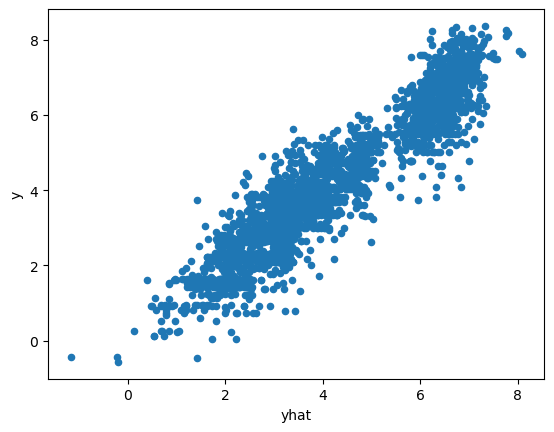

In [8]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



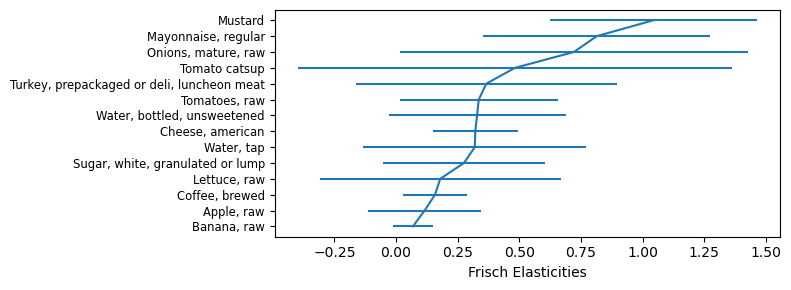

In [60]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [14]:
result.get_beta()

j
Apple, raw                                    0.115564
Banana, raw                                   0.068311
Cheese, american                              0.321181
Coffee, brewed                                0.157900
Lettuce, raw                                  0.178933
Mayonnaise, regular                           0.813618
Mustard                                       1.042876
Onions, mature, raw                           0.720878
Sugar, white, granulated or lump              0.275151
Tomato catsup                                 0.481890
Tomatoes, raw                                 0.335155
Turkey, prepackaged or deli, luncheon meat    0.365707
Water, bottled, unsweetened                   0.328433
Water, tap                                    0.319271
Name: beta, dtype: float64

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [16]:
result.get_gamma()

k,age,sex,log_household,Constant
j,,,,
"Apple, raw",0.000770,-0.042830,-0.011819,4.929221
"Banana, raw",-0.000393,-0.107603,0.019030,4.722747
"Cheese, american",-0.000586,-0.241769,0.044957,3.282297
"Coffee, brewed",0.002082,-0.319526,-0.109818,5.947391
"Lettuce, raw",0.002226,-0.133645,-0.114765,3.175025
"Mayonnaise, regular",-0.001730,-0.542486,-0.085477,2.181799
Mustard,-0.006138,-0.435071,-0.165644,1.801830
"Onions, mature, raw",-0.010710,-0.296790,-0.017852,2.831055
"Sugar, white, granulated or lump",0.000174,-0.415461,-0.027978,2.196712


##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

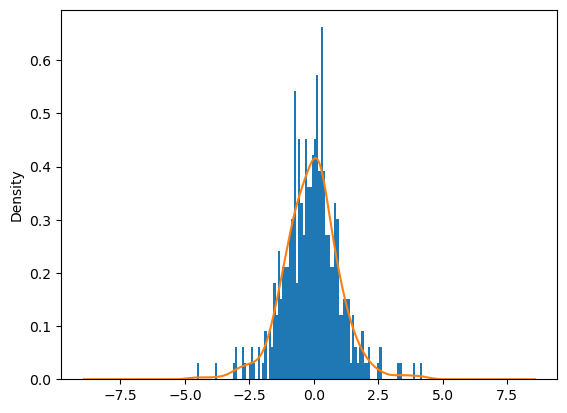

In [15]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [17]:
result.to_pickle('usa_estimates.rgsn')

You can subsequently load this using



In [18]:
import cfe
result = cfe.regression.read_pickle('usa_estimates.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [19]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [14]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



Text(0.5, 0, 'Quantities of Millet Flour Demanded')

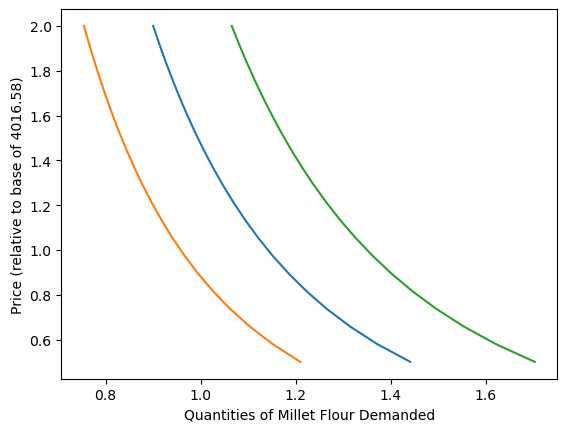

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Millet Flour'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

##### Engel Curves



Engel curves trace out how demand changes with budget:



Text(0.5, 1.0, 'Engel Curves')

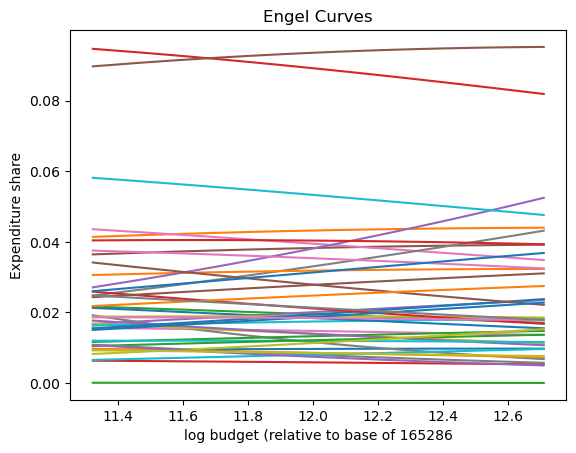

In [16]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



Text(0.5, 1.0, 'Indirect Utility Function')

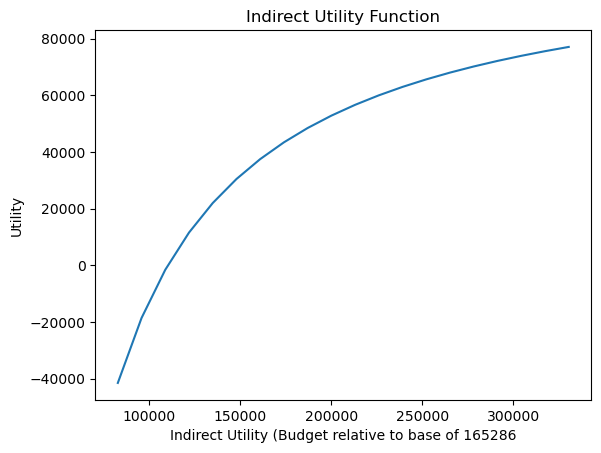

In [17]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')